In [32]:
import numpy as np

def standardize_data(X):
    """
    데이터 행렬 X를 받아서 각 열(특징)별 평균을 제거한 표준화된 데이터를 반환.
    X : (N, D) 형태의 numpy 배열 (N: 샘플 수, D: 특징 수)
    """
    # 각 열별 평균 계산
    mean_vec = np.mean(X, axis=0)
    # 평균을 빼서 원점을 중심으로 이동
    X_centered = X - mean_vec
    return X_centered, mean_vec


def compute_covariance_matrix(X_centered):
    """
    이미 평균 제거된 데이터 X_centered를 받아 공분산 행렬을 계산.
    """
    # 공분산 행렬 계산: (D, D) 형태
    # 일반적으로 공분산은 (1/(N-1)) X^T X 형태
    N = X_centered.shape[0]
    cov_matrix = (X_centered.T @ X_centered) / (N - 1)
    return cov_matrix


def pca_eig_decomposition(X):
    """
    공분산 행렬의 고윳값분해(eigen decomposition)를 이용한 PCA.
    1. 데이터 표준화
    2. 공분산 행렬 계산
    3. 고윳값분해로 주성분 벡터 및 고윳값 획득
    4. 고윳값 내림차순 정렬 및 주성분 벡터 정렬
    """
    # 1. 표준화
    X_centered, mean_vec = standardize_data(X)
    # 2. 공분산 행렬 계산
    cov_matrix = compute_covariance_matrix(X_centered)
    # 3. 고윳값분해
    eig_vals, eig_vecs = np.linalg.eig(cov_matrix)
    # 고윳값 내림차순 정렬
    idx = np.argsort(eig_vals)[::-1]
    eig_vals = eig_vals[idx]
    eig_vecs = eig_vecs[:, idx]
    return eig_vecs, eig_vals, mean_vec


def pca_svd(X):
    """
    SVD를 이용한 PCA 구현.
    1. 데이터 표준화
    2. SVD 수행
    3. V행렬(특징 벡터) 획득 → 주성분 벡터
    """
    X_centered, mean_vec = standardize_data(X)
    # SVD: X_centered = U S V^T
    U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)
    # Vt의 행이 고유벡터의 전치이므로, Vt.T 가 주성분 벡터 집합
    eig_vecs = Vt.T
    # S^2/(N-1)이 고윳값에 해당
    N = X_centered.shape[0]
    eig_vals = (S**2) / (N - 1)
    return eig_vecs, eig_vals, mean_vec


def power_method(A, max_iter=1000, tol=1e-9):
    """
    Power Method를 통해 행렬 A의 최대 고윳값에 대응하는 고유벡터를 근사적으로 찾는다.
    A : (D, D) 형태의 대칭 행렬 (예: 공분산 행렬)
    max_iter: 최대 반복 횟수
    tol: 수렴 기준
    """
    D = A.shape[0]
    # 초기 벡터를 랜덤하게 선정
    v = np.random.randn(D)
    v = v / np.linalg.norm(v)
    
    for _ in range(max_iter):
        v_new = A @ v
        v_new_norm = np.linalg.norm(v_new)
        v_new = v_new / v_new_norm
        # 변화가 매우 작으면 수렴했다고 판단
        if np.linalg.norm(v_new - v) < tol:
            break
        v = v_new
    
    # 최대 고윳값
    eigenvalue = v.T @ A @ v
    eigenvector = v
    return eigenvector, eigenvalue


def get_next_component(A, used_components):
    """
    이미 구한 주성분 방향들(used_components)을 제거한 뒤 다음 주성분 방향 찾기.
    A : 공분산 행렬
    used_components : 이미 구한 주성분 벡터 리스트 [v1, v2, ...]
    
    공분산 행렬에서 이미 구한 주성분을 제거하기 위해서는 
    해당 성분들 방향으로의 투영을 제거한 수정된 행렬을 사용할 수도 있으나, 
    여기서는 단순히 A에 대해서 power_method 적용 시, 
    Gram-Schmidt 정규화를 통한 주성분 제거 후 진행할 수도 있다.
    여기서는 기초 개념이라 pseudo하게 처리.
    """
    # 간단한 방식: used_components에 직교하는 부분공간에서 power method 적용
    # 실제 구현은 A에 대해 필요한 수정이 필요하지만,
    # 여기서는 이해를 돕기 위한 예제 코드 형태로 구현.
    
    # Orthogonal projection to remove used components:
    # A와 commute하는지 명확치 않으나 예제적 코드. 
    # 실제로는 해당 주성분 방향 성분을 제거한 공분산 행렬을 재계산하거나 
    # deflation 기법을 사용해야 한다.
    
    # deflation 기법(단순한 형태):
    M = np.copy(A)
    for comp in used_components:
        # comp 방향 성분 제거
        # deflation: M = M - lambda * comp * comp.T 형태가 일반적이지만 여기서는 단순화
        # 여기서는 수식적인 엄밀함보다는 개념적 예시로서 comp 방향 성분을 제거.
        # 실제 문제 해결 시에는 주성분을 제거한 잔차행렬을 구성하는 방식을 사용.
        
        # 예시로 comp 방향 성분을 제거한다는 개념만 코드로 표현 (정확한 수학적 처리 아님):
        P = np.outer(comp, comp)
        M = M - (M @ comp)[:, None] @ comp[None, :]
        # 위 처리는 정당한 deflation이 아님. 실제로는 eigenvalue와 eigenvector에 따라 
        # M에서 해당 성분을 빼주는 과정이 필요.
        # 여기서는 방법 개념만 제시.
    
    # 제거 후 power method 재적용 (개념적 코드)
    next_vector, next_value = power_method(M)
    return next_vector, next_value


def transform_data(X, eig_vecs, mean_vec, k=None):
    """
    주성분 벡터로 데이터를 변환.
    X : 원본 데이터 (N, D)
    eig_vecs : (D, D) 또는 (D, k) 형태의 주성분 벡터 집합
    mean_vec : 평균 벡터
    k : 사용할 주성분 개수 (None이면 전체 사용)
    """
    X_centered = X - mean_vec
    if k is not None:
        eig_vecs = eig_vecs[:, :k]
    # X_centered에 주성분 축으로 사영
    X_transformed = X_centered @ eig_vecs
    return X_transformed


# 예시 사용
if __name__ == "__main__":
    # 가상의 데이터 생성 (N=100, D=2)
    X = np.array([
        [3.4, 5.1],
        [1.2, -1.2]])  # 단순한 가우시안 데이터
    
    # 1. 고윳값분해를 사용한 PCA
    eig_vecs_eig, eig_vals_eig, mean_vec_eig = pca_eig_decomposition(X)
    
    # 2. SVD를 사용한 PCA
    eig_vecs_svd, eig_vals_svd, mean_vec_svd = pca_svd(X)
    
    # 3. Power Method 사용 예시 (최대 고윳값 고유벡터 찾기)
    X_centered, _ = standardize_data(X)
    cov_matrix = compute_covariance_matrix(X_centered)
    principal_vector, principal_value = power_method(cov_matrix)
    
    # 4. 특정 점(3,5)를 주성분 벡터를 이용해 변환해보는 예제
    point = np.array([[3, 5]])  # (1,2) 형태
    # eig_vecs_eig는 (2,2) 형태. 첫 번째 두 주성분 방향으로 투영
    point_transformed = transform_data(point, eig_vecs_eig, mean_vec_eig, k=2)
    # point_transformed가 (2,1) 형태의 새로운 좌표계 상의 점을 나타냄
    
    # 출력
    print("Eigen Decomposition 기반 PCA 주성분 벡터:\n", eig_vecs_eig)
    print("Power Method로 구한 최대 고윳값 고유벡터:\n", principal_vector)
    print("(3,5) 점을 주성분 축으로 변환한 좌표:\n", point_transformed)
    
import numpy as np

# 원하는 데이터를 직접 배열로 정의 (예: 리스트를 통한 정의)
# X = np.array([
#     [1.2, 3.4],
#     [2.5, 4.1],
#     [3.0, 3.3],
#     # ... 이와 같이 계속해서 데이터 포인트를 정의 ...
# ])

# CSV 파일에서 데이터 불러오기
# data.csv 내부는 각 행이 하나의 샘플, 열이 특징값이라고 가정
# X = np.loadtxt("data.csv", delimiter=",")
# import pandas as pd
# df = pd.read_csv("data.csv")
# X = df.values  # DataFrame을 numpy 배열로 변환

Eigen Decomposition 기반 PCA 주성분 벡터:
 [[-0.32968283 -0.94409175]
 [-0.94409175  0.32968283]]
Power Method로 구한 최대 고윳값 고유벡터:
 [0.32968283 0.94409175]
(3,5) 점을 주성분 축으로 변환한 좌표:
 [[-3.11025782  0.34466842]]


In [34]:
import numpy as np

def standardize_data(X):
    """
    데이터 행렬 X를 받아서 각 열(특징)별 평균을 제거한 표준화된 데이터를 반환.
    X : (N, D) 형태의 numpy 배열 (N: 샘플 수, D: 특징 수)
    """
    mean_vec = np.mean(X, axis=0)
    X_centered = X - mean_vec
    return X_centered, mean_vec

def compute_covariance_matrix(X_centered):
    """
    이미 평균 제거된 데이터 X_centered를 받아 공분산 행렬을 계산.
    """
    N = X_centered.shape[0]
    cov_matrix = (X_centered.T @ X_centered) / (N - 1)
    return cov_matrix

def power_method(A, max_iter=1000, tol=1e-9):
    """
    Power Method를 통해 행렬 A의 최대 고윳값에 대응하는 고유벡터를 근사적으로 찾는다.
    A : (D, D) 형태의 대칭 행렬 (예: 공분산 행렬)
    max_iter: 최대 반복 횟수
    tol: 수렴 기준
    """
    D = A.shape[0]
    v = np.random.randn(D)
    v /= np.linalg.norm(v)
    
    for _ in range(max_iter):
        v_new = A @ v
        v_new_norm = np.linalg.norm(v_new)
        v_new = v_new / v_new_norm
        if np.linalg.norm(v_new - v) < tol:
            break
        v = v_new
    
    eigenvalue = v.T @ A @ v
    eigenvector = v
    return eigenvector, eigenvalue

def deflate_matrix(A, eigenvalue, eigenvector):
    """
    이미 얻은 한 고유벡터(eigenvector)와 해당 고윳값(eigenvalue)에 따라
    행렬 A에서 해당 성분을 제거(Deflation)하여 새로운 행렬 A_new를 반환.
    A_new = A - eigenvalue * eigenvector * eigenvector^T
    """
    v = eigenvector[:, np.newaxis]  # (D,1) 형태로 변환
    A_new = A - eigenvalue * (v @ v.T)
    return A_new

# 예시: 첫 번째 주성분을 구한 뒤, 두 번째 주성분을 찾는 과정
if __name__ == "__main__":
    # 가상의 데이터 생성 (N=5, D=3)
    np.random.seed(0)
    X = np.array([
        [3.4, 5.1],
        [1.2, -1.2]])  # 예시용 작은 데이터
    
    # 데이터 표준화
    X_centered, _ = standardize_data(X)
    
    # 공분산 행렬
    cov_matrix = compute_covariance_matrix(X_centered)
    
    # 첫 번째 주성분 (최대 고윳값 방향) 찾기
    v1, lambda1 = power_method(cov_matrix)
    print("첫 번째 주성분 벡터:", v1)
    print("첫 번째 주성분에 대응하는 고윳값:", lambda1)
    
    # 첫 번째 주성분 제거(Deflation)
    cov_matrix_deflated = deflate_matrix(cov_matrix, lambda1, v1)
    
    # 두 번째 주성분 찾기
    v2, lambda2 = power_method(cov_matrix_deflated)
    print("두 번째 주성분 벡터:", v2)
    print("두 번째 주성분에 대응하는 고윳값:", lambda2)


첫 번째 주성분 벡터: [0.32968283 0.94409175]
첫 번째 주성분에 대응하는 고윳값: 22.265
두 번째 주성분 벡터: [0.16658812 0.98602657]
두 번째 주성분에 대응하는 고윳값: -1.0958254597908522e-14


In [4]:
from sklearn.datasets import load_iris

iris = load_iris()
iris

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

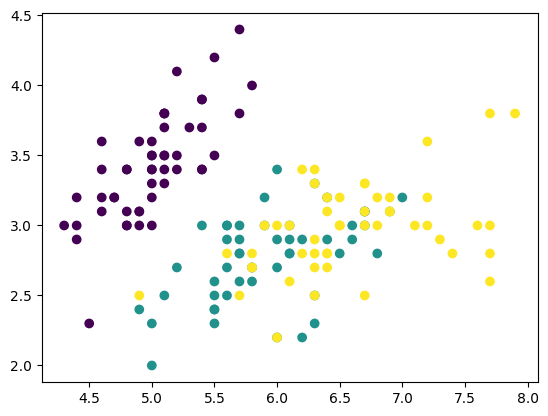

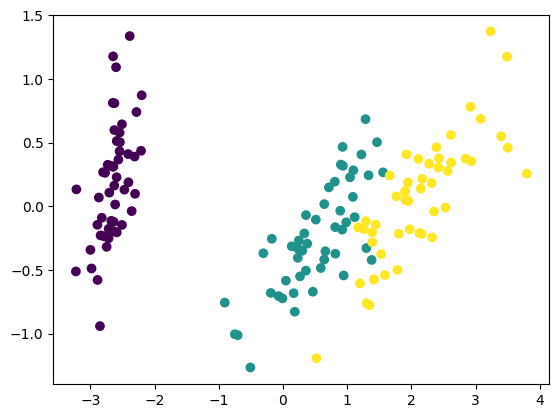

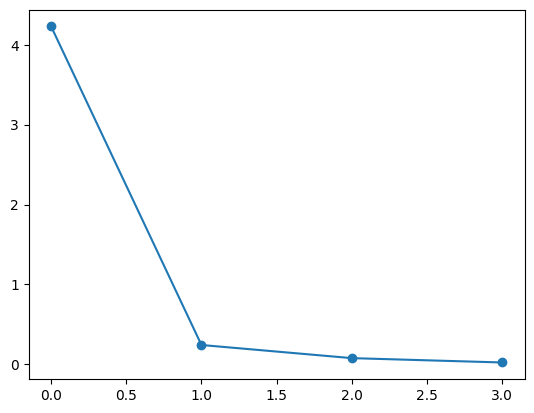

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=4)   

X = iris['data']
Y = pca.fit_transform(iris['data'])

plt.scatter(X[:,0], X[:,1], c=iris['target'])
plt.show()

plt.scatter(Y[:,0], Y[:,1], c=iris['target'])
plt.show()

plt.plot(pca.explained_variance_, "-o")
plt.show()

# plt.plot(range(1, 5), pca.explained_variance_, "-o")
# plt.show()

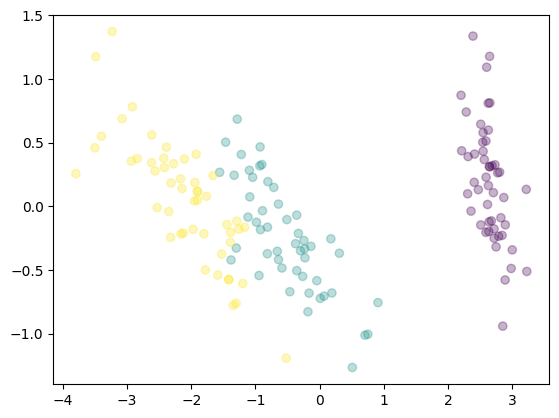

In [6]:
#Eigen decomposition은 행렬을 벡터와 람다값으로 분해해준다?
#다만 행렬이 정사각형만 가능하다
#M = QlambdaQ(T)
from numpy import linalg
import matplotlib.pyplot as plt

X = iris['data']
X = X - X.mean(axis=0)

C = (X.T @ X) / X.shape[0]

#아이젠 함수 L, Q반환
L, Q = linalg.eigh(C)
Y = X @ Q

#L, Q의 3, 2번째를 고름
#3, 2번째를 고르는 이유는 아이젠 함수가 제일 큰 벡터를 뒤에 두기 때문이다.
plt.scatter(Y[:,3], Y[:,2],c=iris['target'], alpha=0.3)
plt.show()

#처음의 그래프와 반전되어서 나타나는 이유
#주성분이 선 위에 있는게 중요하지 어차피 분산 값은 똑같음. 즉 방향 자체는 중요하지 않다.


In [7]:
#power method => largest eigen value와 largest eigen vector를 구해준다.
#Mv = lambdav => lambda 값이 제일 클때의 v를 구해준다.
#Mv = v1이고 Mv1 = v2 이런식으로 계속 돌려가면서 구한다. 이걸 반복
#그럼 결국엔 하나의 벡터로 수렴을 하게됨
#이게 largest eigen vector로 수렴하게 된다.
from numpy import linalg
import matplotlib.pyplot as plt
import numpy as np

X = iris['data']
X = X - X.mean(axis=0)

#공분산
C = (X.T @ X) / len(X)

M = C.copy()

L=[]
Q=[]

#정규화
v = np.random.randn(4, 1)
v /= linalg.norm(v)

#power method
for i in range(4):
    for _ in range(20):    
        vp = M @ v
        lmb = linalg.norm(vp)
        vp /= lmb
        v = vp
        
    M -= lmb * (v @ v.T)
    
    L.append(lmb)
    Q.append(v)

L = np.array(L)
Q = np.hstack(Q)

print(L, Q)

[4.20005343 0.24105294 0.0776881  0.02367619] [[ 0.36138659  0.65658877 -0.58202985 -0.31548719]
 [-0.08452251  0.73016143  0.59791083  0.3197231 ]
 [ 0.85667061 -0.17337266  0.07623608  0.47983899]
 [ 0.3582892  -0.07548102  0.54583143 -0.75365743]]


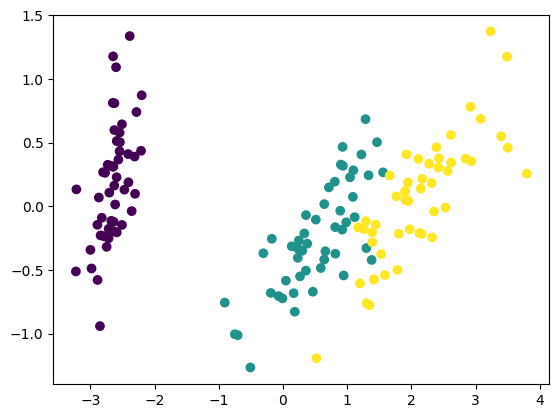

In [8]:
Y = X @ Q
plt.scatter(Y[:,0], Y[:,1], c=iris['target'])
plt.show()

In [35]:
#pagerank
import requests

with open("example_index", "wb") as f:
    r = requests.get("https://webdatacommons.org/hyperlinkgraph/data/example_index")
    f.write(r.content)

with open("example_arcs", "wb") as f:
    r = requests.get("https://webdatacommons.org/hyperlinkgraph/data/example_arcs")
    f.write(r.content)


In [36]:
import numpy as np

nodes = np.loadtxt("example_index", dtype=object)[:,0]
num_nodes = nodes.shape[0]
edges = np.loadtxt("example_arcs", dtype=int)
num_edges = nodes.shape[0]

print(nodes)
print(edges)

['1000notes.com' '100500.tv' 'abebooks.com' 'abebooks.de'
 'amazon-presse.de' 'amazon.ca' 'amazon.cn' 'amazon.co.jp' 'amazon.co.uk'
 'amazon.com' 'amazon.de' 'amazon.es' 'amazon.fr' 'amazon.it'
 'angrybirds.com' 'animationplayhouse.com' 'apple.com' 'audible.com'
 'audible.de' 'automattic.com' 'azspot.net' 'beautybar.com'
 'blogalaxia.com' 'blogg.se' 'blogia.com' 'blogspot.com'
 'bookdepository.co.uk' 'bookdepository.com' 'buyvip.com' 'canalblog.com'
 'carambatv.ru' 'classicalvalues.com' 'creativecommons.org'
 'cubicle17.com' 'cyprien.fr' 'diapers.com' 'disqus.com'
 'downthisvideo.com' 'dpreview.com' 'drdrum.com'
 'eltangoysusinvitados.com' 'endless.com' 'fabric.com' 'facebook.com'
 'flickr.com' 'flickr.net' 'gmpg.org' 'goodreads.com' 'google.com'
 'histats.com' 'hockeyfights.com' 'icecastles.com' 'imdb.com' 'imdb.de'
 'img-dpreview.com' 'instagr.am' 'javari.de' 'javari.jp' 'joblo.com'
 'kenyaunlimited.com' 'linkwithin.com' 'livejournal.com' 'lockerz.com'
 'lovefilm.de' 'memeorandum.com

In [37]:
import networkx as nx
import matplotlib.pyplot as plt

plt.figure(dpi=300)
G = nx.DiGraph()

for u, v in edges:
    G.add_edge(nodes[u], nodes[v])
# pagerank에 들어가는 0.8은 teleport가 되지 않는 확률
# 기본값 0.85
r = nx.pagerank(G)
6
r = sorted(r.items(), key=lambda x: x[1], reverse=True)

for i in r[:10]:
    print(i)

('blogspot.com', 0.08542425762544206)
('creativecommons.org', 0.024220103814991234)
('wikipedia.org', 0.021582586522641486)
('canalblog.com', 0.017730661911958275)
('youtube.com', 0.016119265401656313)
('tumblr.com', 0.015904254686443048)
('google.com', 0.015904254686443048)
('wikimedia.org', 0.015599528017970031)
('rea-group.com', 0.015057970139281873)
('yahoo.com', 0.013150763969634)


<Figure size 1920x1440 with 0 Axes>

In [38]:
def pagerank(edges, n_nodes,beta=0.85, n_epochs=100):
    
    d = [0] * n_nodes
    
    for u, v in edges:
        d[u] += 1
    
    r = [1/n_nodes] * n_nodes
    
    for _ in range(n_epochs):
        r_next = [(1-beta) / n_nodes] * n_nodes
    
        for u, v in edges:
            r_next[v] += beta * r[u] / d[u]
            
        r_next_sum = sum(r_next)
        for u in range(n_nodes):
            r_next[u] += (1-r_next_sum) / n_nodes
            
        r = r_next

    return r
              
        

In [39]:
r = pagerank(edges, num_nodes)
for item in sorted((zip(r, nodes)), reverse=True)[:10]:
    print(item) 


(0.08542594911159555, 'blogspot.com')
(0.02422019737380686, 'creativecommons.org')
(0.021582303280083363, 'wikipedia.org')
(0.01773120753338568, 'canalblog.com')
(0.01611902130484473, 'youtube.com')
(0.01590404148659131, 'tumblr.com')
(0.01590404148659131, 'google.com')
(0.015599869453139698, 'wikimedia.org')
(0.01505780846024519, 'rea-group.com')
(0.013150737408590827, 'yahoo.com')


In [ ]:
#networkAnalysis

from urllib.parse import unquote
import networkx as nx

G = nx.DiGraph()
with open("articles.tsv") as f:
    for line in f:
        line = line.strip()
        if line == "" or line[0] == "#": continue
        
        G.add_node(unquote(line)) # %로 인코딩된 문자열 정상화
        
with open("links.tsv") as f:
    for line in f:
        line = line.strip()
        if line == "" or line[0] == "#": continue
        
        u, v = line.split()
        u = unquote(u)
        v = unquote(v)
        G.add_edge(u, v)

In [43]:
n_nodes = len(G.nodes)
n_edges = len(G.edges)
density = nx.density(G) # n_edges * 2 / (n_nodes * (n_nodes - 1)))

n_triangles = sum(nx.triangles(G.to_undirected()).values())//3

print("n_nodes", n_nodes)
print("n_edges", n_edges)
print("density", density)
print("n_triangles", n_triangles)

n_nodes 4604
n_edges 119882
density 0.0056568894271159615
n_triangles 550545


In [44]:
degree = nx.degree_centrality(G)
indegree = nx.in_degree_centrality(G)
outdegree = nx.out_degree_centrality(G)
betweenness = nx.betweenness_centrality(G, 200) 
closeness = nx.closeness_centrality(G)
clustering = nx.clustering(G)
triangles = nx.triangles(G.to_undirected())
pagerank = nx.pagerank(G)

In [45]:
print("Degree Rank")
for line in sorted(degree.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(line)
    
print("PageRank Rank")
for line in sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(line)  
    
print("Closeness Rank")
for line in sorted(closeness.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(line)  

Degree Rank
('United_States', 0.40082554855529)
('United_Kingdom', 0.24766456658700847)
('Europe', 0.23723658483597654)
('France', 0.2268086030849446)
('England', 0.2005213990875516)
('Germany', 0.19813165326960677)
('World_War_II', 0.18900716923745384)
('English_language', 0.15555072778622636)
('India', 0.1503367369107104)
('Africa', 0.1496849880512709)
PageRank Rank
('United_States', 0.00956180652731311)
('France', 0.0064200413810133585)
('Europe', 0.006337014005458885)
('United_Kingdom', 0.006232394913963077)
('English_language', 0.004862980440047761)
('Germany', 0.00482224267836269)
('World_War_II', 0.0047226367934437305)
('England', 0.0044723357530703466)
('Latin', 0.004422148441338466)
('India', 0.004033922521194668)
Closeness Rank
('United_States', 0.5888144495179611)
('Europe', 0.5413350441257859)
('United_Kingdom', 0.5400542324751866)
('France', 0.5383982105334064)
('Germany', 0.5229184910782076)
('World_War_II', 0.5220812473825197)
('Latin', 0.5121245711367234)
('English_lang

In [46]:
import matplotlib.pyplot as plt

nodes = G.nodes

deg_arr = [degree[node] for node in nodes]
indeg_arr = [indegree[node] for node in nodes]
outdeg_arr = [outdegree[node] for node in nodes]
bw_arr = [betweenness[node] for node in nodes]
cl_arr = [closeness[node] for node in nodes]
pr_arr = [pagerank[node] for node in nodes]
cc_arr = [clustering[node] for node in nodes]
tr_arr = [triangles[node] for node in nodes]



In [47]:
for node in nodes:
    if outdegree[node] > 0.05 and triangles[node] < 10000:
        print(node)


Driving_on_the_left_or_right
List_of_circulating_currencies
List_of_countries


In [48]:
for i, p in enumerate(sorted(pagerank.items(), reverse=True, key=lambda x:x[1])):
    if p[0] == "Driving_on_the_left_or_right":
        print(i, p)

4258 ('Driving_on_the_left_or_right', 3.269755596654361e-05)


In [ ]:
threshold = 0.4
anomalies = [node for node, centrality in degree.items() if centrality > threshold] # 어노말리 찾기
anomalies

['United_States']

In [58]:
# -*- coding: utf-8 -*-
# 주어진 일반 메일과 스팸 메일 데이터를 바탕으로 새로운 메일이 스팸일 확률과 일반 메일일 확률을 계산하는 코드 예시
# 확률 계산 시 스무딩 기법(Laplace smoothing)을 적용하고, 로그 변환을 통해 수치적 안정성을 확보
# 또한 예측 결과(스팸/일반)에 대해 precision, recall, f1 score, accuracy를 계산하는 예시 포함

import math
import csv

def read_emails_from_csv(filepath):
    emails = []
    with open(filepath, 'r', encoding='utf-8') as f:
        reader = csv.reader(f)
        for row in reader:
            # CSV의 각 행에서 첫 번째 컬럼을 이메일로 가정
            emails.append(row[0].strip())
    return emails

# 기존의 리스트로 직접 정의했던 부분을 CSV 읽기 함수로 변경
normal_emails = read_emails_from_csv("normal.csv")
spam_emails = read_emails_from_csv("spam.csv")
# 샘플 데이터 (실제 시험 문제에서는 별도 제공될 수 있음)
# 일반 메일 5개 예시
# normal_emails = [
#     "안녕하세요 오늘 일정 확인 부탁드립니다",
#     "회의 자료 첨부하였습니다 검토 부탁드립니다",
#     "프로젝트 진행 상황 공유드립니다",
#     "이번주 금요일 회의 안건 확정되었습니다",
#     "새로운 팀원이 합류했습니다 인사 부탁드립니다"
# ]

# # 스팸 메일 5개 예시
# spam_emails = [
#     "지금 바로 클릭하면 당첨 기회",
#     "한정 할인 코드 지금 입력",
#     "무료 쿠폰 증정 이벤트",
#     "당신에게만 드리는 특별한 제안",
#     "바로 신청하세요 놓치지 마세요"
# ]

# 전처리 함수: 간단히 공백 기준 토큰화
def tokenize_email(email):
    return email.strip().split()

# 각 단어 출현 빈도 계산
def build_word_counts(emails):
    word_counts = {}
    for email in emails:
        for word in tokenize_email(email):
            if word not in word_counts:
                word_counts[word] = 0
            word_counts[word] += 1
    return word_counts

# 단어 출현 빈도 사전 생성
normal_word_counts = build_word_counts(normal_emails)
spam_word_counts = build_word_counts(spam_emails)

# 단어 사전(유니버스) 구성: 모든 메일에 등장한 단어들
all_words = set(list(normal_word_counts.keys()) + list(spam_word_counts.keys()))

# 메일 집합의 총 메일 수
num_normal = len(normal_emails)
num_spam = len(spam_emails)

# 사전확률(P(정상), P(스팸))
p_normal = num_normal / (num_normal + num_spam)
p_spam = num_spam / (num_normal + num_spam)

# 라플라스 스무딩(Laplace smoothing) 상수
alpha = 1.0

# 단어 출현 확률 계산 함수
# P(단어 | 정상) 또는 P(단어 | 스팸)을 계산할 때
# 스무딩을 적용: (해당 단어 출현 빈도 + α) / (전체 단어 출현 총합 + α * 전체 단어 개수)
def word_prob(word, word_counts, total_words):
    return (word_counts.get(word, 0) + alpha) / (total_words + alpha * len(all_words))

# 전체 단어 출현 수 계산
total_normal_words = sum(normal_word_counts.values())
total_spam_words = sum(spam_word_counts.values())

# 새로운 메일이 주어졌을 때 스팸일 확률과 일반 메일일 확률 계산 함수 (로그 적용)
def predict_spam_probability(new_email):
    words = tokenize_email(new_email)
    
    # 로그 확률 계산
    # P(정상|메일) ~ logP(정상) + ΣlogP(단어|정상)
    # P(스팸|메일) ~ logP(스팸) + ΣlogP(단어|스팸)
    log_normal = math.log(p_normal)
    log_spam = math.log(p_spam)
    
    for w in words:
        # 단어별 조건부 확률 로그합산
        log_normal += math.log(word_prob(w, normal_word_counts, total_normal_words))
        log_spam += math.log(word_prob(w, spam_word_counts, total_spam_words))
    
    # 이제 exp를 통해 확률 비율 구하기
    # P(스팸|메일) = exp(log_spam) / [exp(log_spam) + exp(log_normal)]
    # P(정상|메일) = exp(log_normal) / [exp(log_spam) + exp(log_normal)]
    denom = math.exp(log_spam) + math.exp(log_normal)
    p_spam_given_mail = math.exp(log_spam) / denom
    p_normal_given_mail = math.exp(log_normal) / denom
    return p_spam_given_mail, p_normal_given_mail

# 테스트 데이터(정답 라벨 포함): 새로운 메일 4개 (2개는 스팸, 2개는 정상 가정)
test_emails = [
    ("이번 주 회의 자료 확인 바랍니다", "normal"),
    ("지금 신청하세요 특별 혜택 제공", "spam"),
    ("새로운 팀원 인사 확인", "normal"),
    ("무료 쿠폰 놓치지 마세요", "spam")
]

# 예측 수행
y_true = []
y_pred = []

for email, label in test_emails:
    p_s, p_n = predict_spam_probability(email)
    # 스팸 확률이 더 높으면 스팸으로 예측
    predicted_label = "spam" if p_s > p_n else "normal"
    y_true.append(label)
    y_pred.append(predicted_label)

# 성능 지표 계산
# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN)
# F1 = 2 * (Precision * Recall) / (Precision + Recall)
# Accuracy = (TP + TN) / (TP + TN + FP + FN)
def calculate_metrics(y_true, y_pred, positive_label="spam"):
    tp = sum((yt == positive_label and yp == positive_label) for yt, yp in zip(y_true, y_pred))
    fp = sum((yt != positive_label and yp == positive_label) for yt, yp in zip(y_true, y_pred))
    fn = sum((yt == positive_label and yp != positive_label) for yt, yp in zip(y_true, y_pred))
    tn = sum((yt != positive_label and yp != positive_label) for yt, yp in zip(y_true, y_pred))
    
    precision = tp / (tp + fp) if (tp+fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp+fn) > 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision+recall) > 0 else 0.0
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    return precision, recall, f1, accuracy

precision, recall, f1, accuracy = calculate_metrics(y_true, y_pred, positive_label="spam")

# 결과 출력
print("예측 결과:")
for (email, label), pred in zip(test_emails, y_pred):
    print(f"메일: '{email}', 실제: {label}, 예측: {pred}")

print("\n성능 지표:")
print(f"Precision(스팸 기준): {precision:.4f}")
print(f"Recall(스팸 기준): {recall:.4f}")
print(f"F1 Score(스팸 기준): {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(normal_emails)
print(spam_emails)


예측 결과:
메일: '이번 주 회의 자료 확인 바랍니다', 실제: normal, 예측: normal
메일: '지금 신청하세요 특별 혜택 제공', 실제: spam, 예측: spam
메일: '새로운 팀원 인사 확인', 실제: normal, 예측: normal
메일: '무료 쿠폰 놓치지 마세요', 실제: spam, 예측: spam

성능 지표:
Precision(스팸 기준): 1.0000
Recall(스팸 기준): 1.0000
F1 Score(스팸 기준): 1.0000
Accuracy: 1.0000
['안녕하세요 오늘 일정 확인 부탁드립니다', '회의 자료 첨부하였습니다 검토 부탁드립니다', '프로젝트 진행 상황 공유드립니다', '이번주 금요일 회의 안건 확정되었습니다', '새로운 팀원이 합류했습니다 인사 부탁드립니다']
['지금 바로 클릭하면 당첨 기회', '한정 할인 코드 지금 입력', '무료 쿠폰 증정 이벤트', '당신에게만 드리는 특별한 제안', '바로 신청하세요 놓치지 마세요']


In [59]:
import re

labels = []
data = []
with open("/home/user/바탕화면/programming/data_science/naive_bayes/SMSSpamCollection", "r") as f:
    for line in f:
        label, txt = line.split("\t")
        labels.append(label)
        
        data.append((label, set(re.findall("[a-z0-9_]+", txt.lower()))))
        

In [60]:
import random
random.shuffle(data)

n_train = int(len(data) * 0.8)

train = data[:n_train]
test = data[n_train:]

In [61]:
import math
alpha = 1e-4

n_ham = sum(1 for label, txt in train if label == 'ham')
n_spam = sum(1 for label, txt in train if label == 'spam')


prior_ham = math.log((n_ham + alpha) / (n_train + 2*alpha))
prior_spam = math.log((n_spam + alpha) / (n_train + 2*alpha)) 

prior_ham, prior_spam

(-0.14270416384577722, -2.0174852818488067)

In [62]:
from collections import defaultdict

word_ham = defaultdict(lambda : 0)
word_spam = defaultdict(lambda : 0)

for label, txt in train:
    for word in txt:
        if label == 'ham':
            word_ham[word] += 1
            
        else:
            word_spam[word] += 1
            
like_ham = defaultdict(lambda : math.log(alpha / (n_ham + alpha)))
like_spam = defaultdict(lambda : math.log(alpha / (n_spam + alpha)))

for word, cnt in word_ham.items():
    like_ham[word] = math.log((cnt + alpha) / (n_ham + alpha))
    
for word, cnt in word_spam.items():
    like_spam[word] = math.log((cnt + alpha) / (n_spam + alpha))


In [63]:
def predict(bow):
    ham_score = prior_ham
    spam_score = prior_spam
    for word in bow:
        ham_score += like_ham[word]
        spam_score += like_spam[word]
        
    if ham_score > spam_score:
        return 'ham'
    else:
        return 'spam'
    
    
        

In [64]:
test


[('ham',
  {'2',
   'at',
   'cut',
   'decided',
   'havent',
   'hee',
   'i',
   'it',
   'paragon',
   's',
   'whether',
   'yet',
   'yup'}),
 ('ham',
  {'3',
   'at',
   'derek',
   'house',
   'lt',
   'now',
   's',
   'see',
   'sunday',
   'yep',
   'you'}),
 ('ham',
  {'but',
   'e',
   'i',
   'in',
   'lazy',
   'lor',
   'm',
   'mode',
   'not',
   'studying',
   'surfing',
   'today',
   'yup'}),
 ('ham', {'4', 'all', 'best', 'driving', 'e', 'tmr', 'ur'}),
 ('ham', {'funny', 'him', 'me', 'n', 'so'}),
 ('ham',
  {'and',
   'be',
   'but',
   'by',
   'call',
   'capital',
   'complete',
   'ending',
   'far',
   'for',
   'how',
   'i',
   'is',
   'ladies',
   'march',
   'my',
   'never',
   'problem',
   'ready',
   's',
   'should',
   'sure',
   'that',
   'the',
   'will',
   'with',
   'work',
   'you'}),
 ('ham',
  {'all',
   'at',
   'belt',
   'cribbs',
   'hat',
   'is',
   'jumpers',
   'know',
   'people',
   'r',
   'shirts',
   't',
   'we',
   'wear',
  

In [65]:
# accuracy = 맞은 데이터 수 / 전체 데이터 수
# precision? = tp / (tp + fp)
# 넌 던한테 잘해 게이게이게이야 트리플 게이

tp, fp, tn, fn = 0, 0, 0, 0

for label, txt in test:
    result = predict(txt)
    if result == 'spam' and label == 'spam':
        tp += 1
    elif result == 'spam' and label == 'ham':
        fp += 1
    elif result == 'ham' and label == 'ham':
        tn += 1
    elif result == 'ham' and label == 'spam':
        fn += 1
        
tp, fp, tn, fn 

(151, 33, 928, 3)

In [66]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
recall = tp / (tp + fn)
precision = tp / (tp + fp)
f1 = 2 * recall * precision / (recall + precision)

print(accuracy, recall, precision, f1)

0.967713004484305 0.9805194805194806 0.8206521739130435 0.893491124260355


In [ ]:
# email csv에서 비어있는 구간 전처리 해야할 경우
import csv

emails = []
with open("example.csv", 'r', encoding='utf-8') as f:
    reader = csv.reader(f)
    for row in reader:
        # row가 비어있거나, 이메일 컬럼(row[0])이 비었을 경우 처리
        if not row or not row[0].strip():
            # 비어있는 경우 대체값을 넣거나 아예 스킵할 수 있다.
            # 여기서는 "N/A"로 대체하는 예시
            emails.append("N/A")
        else:
            # 정상적인 값이 있는 경우 그대로 사용
            emails.append(row[0].strip())

print(emails)

# 이건 그냥ㅇ 넘기는 거
if not row or not row[0].strip():
    continue
else:
    emails.append(row[0].strip())


In [67]:
# 다음은 위에서 구현한 compute_topic_probabilities 함수를 실제 데이터(예: 임의로 가짜 데이터)를 사용하여
# 호출하고 결과를 확인하는 예시이다.
#
# 가정 상황:
# - 전체 단어 수 V = 5
# - 토픽 수 K = 3
# - 문서 수 D = 4
# - alpha = 0.1
# - beta = 0.01
#
# word_topic_counts, doc_topic_counts, topic_counts는 실제 LDA 학습 과정 중에 업데이트되는 카운트 테이블이다.
# 여기서는 간단히 임의의 숫자로 예를 들어 보여준다.

import numpy as np

# 가상의 단어-토픽 카운트 (V x K)
word_topic_counts = np.array([
    [10,  2,  0],  # 단어0이 토픽0:10회, 토픽1:2회, 토픽2:0회
    [ 0,  5,  3],  # 단어1이 토픽0:0회,  토픽1:5회, 토픽2:3회
    [ 4,  1,  7],  # 단어2가 토픽0:4회,  토픽1:1회, 토픽2:7회
    [ 8, 10,  2],  # 단어3가 토픽0:8회,  토픽1:10회,토픽2:2회
    [ 2,  2,  2]   # 단어4가 토픽0:2회,  토픽1:2회, 토픽2:2회
])

# 가상의 문서-토픽 카운트 (D x K)
doc_topic_counts = np.array([
    [ 2,  3,  1], # 문서0에서 토픽0:2회, 토픽1:3회, 토픽2:1회
    [10,  1,  0], # 문서1에서 토픽0:10회,토픽1:1회, 토픽2:0회
    [ 0,  5,  5], # 문서2에서 토픽0:0회, 토픽1:5회, 토픽2:5회
    [ 1,  1,  1]  # 문서3에서 토픽0:1회, 토픽1:1회, 토픽2:1회
])

# 토픽별 전체 단어 할당 횟수 (길이 K)
topic_counts = np.sum(word_topic_counts, axis=0)  # 열 합계
# topic_counts는 [단어토픽카운트 행렬]에서 각 토픽열을 합산한 결과
# 예: topic_counts = [10+0+4+8+2, 2+5+1+10+2, 0+3+7+2+2] = [24, 20, 14]

alpha = 0.1
beta = 0.01

def compute_topic_probabilities(w, d, word_topic_counts, doc_topic_counts, topic_counts, alpha, beta):
    V = len(word_topic_counts)
    K = len(topic_counts)
    topic_probs = []
    for k in range(K):
        word_topic_factor = (word_topic_counts[w][k] + beta) / (topic_counts[k] + V * beta)
        doc_topic_factor = (doc_topic_counts[d][k] + alpha) / (sum(doc_topic_counts[d]) + K * alpha)
        p_k = word_topic_factor * doc_topic_factor
        topic_probs.append(p_k)
    total = sum(topic_probs)
    if total > 0:
        topic_probs = [p / total for p in topic_probs]
    else:
        topic_probs = [1.0 / K] * K
    return topic_probs

# 예를 들어, 단어 w=3(단어 ID가 3인 단어)와 문서 d=2에 대해
# 토픽 할당 확률을 계산해보자.
w = 3
d = 2

probabilities = compute_topic_probabilities(w, d, word_topic_counts, doc_topic_counts, topic_counts, alpha, beta)

print("단어 w={}를 문서 d={}에 할당할 때 각 토픽별 확률 분포:".format(w, d))
for k, p in enumerate(probabilities):
    print("토픽 {}: {:.4f}".format(k, p))


단어 w=3를 문서 d=2에 할당할 때 각 토픽별 확률 분포:
토픽 0: 0.0101
토픽 1: 0.7694
토픽 2: 0.2205
